# Preparing data for GOLD annotations using Argilla.

In [119]:
# Importing necessary libraries
import argilla as rg
import pandas as pd
from tabulate import tabulate
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



In [120]:
# Setting display options for better readability
# pd.set_option("display.max_colwidth", 30)  # Adjust the number to your preference

# Loading the dataset
file_path = '/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/data_to_annotate/vaers_all_to_annotate.csv'

# Load the CSV file
vaers_all_to_annotate = pd.read_csv(file_path, delimiter=",")

vaers_all_to_annotate.head()

# Print the first two columns as a table
#print(tabulate(vaers_all_to_annotate, headers="keys", tablefmt="psql"))

,VAERS_ID,SYMPTOM_TEXT,YEAR
0,902418,Patient experienced mild n...,2020
1,902440,C/O Headache,2020
2,902446,"felt warm, hot and face an...",2020
3,902464,within 15 minutes progress...,2020
4,902465,Pt felt wave come over bod...,2020


In [107]:
# Checking total number of rows
len(vaers_all_to_annotate)

1111040

## Applying schuffel to the df so we have records from all years while annotating

In [ ]:
vaers_all_to_annotate_shuffled = vaers_all_to_annotate.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
vaers_all_to_annotate_shuffled.head(60)

In [ ]:
# Convert the 'vaers_all_to_annotate' DataFrame to a dictionary to load into Argilla
vaers_all_to_annotate_shuffled_dict = {
    row['VAERS_ID']: {'SYMPTOM_TEXT': row['SYMPTOM_TEXT'], 'YEAR': row['YEAR']}
    for _, row in vaers_all_to_annotate_shuffled.iterrows()
}


In [ ]:
vaers_all_to_annotate_shuffled_dict

## Filtering only the first 500 records for GOLD Annotations!

In [ ]:
# Filtering only the first 500 records for GOLD Annotations using islice from itertools.
first_500_dict = dict(islice(vaers_all_to_annotate_shuffled_dict.items(), 500))

In [84]:
# Extract all YEAR values into a list
years = [record["YEAR"] for record in first_500_dict.values() if "YEAR" in record]

# Convert to pandas Series and count values
year_counts = pd.Series(years).value_counts()
year_counts

2021    331
2022    122
2023     30
2024     11
2020      5
2025      1
dtype: int64

In [52]:
len(first_500_dict)

500

## Argilla Set Up

In [50]:
# Connecting to Argilla server
client = rg.Argilla(
    api_url="http://localhost:6900/",
    api_key="admin.apikey",
    # extra_headers={"Authorization": f"Bearer {"HF_TOKEN"}"}
)

In [ ]:
# Defining the annotation settings and creating the dataset in Argilla
settings = rg.Settings(
    guidelines="Need to be uploaded",
    fields=[
        rg.TextField(
            name="text",
            title="SYMPTOM_TEXT",
            use_markdown=False
        ),
    ],
    questions=[
        rg.SpanQuestion(
            name="tokens",
            title="Tokens",
            required=True,
            allow_overlapping = True,
            field="text",
            labels=["ADE", "DRUG"]
        ),
    ],
    metadata=[
        rg.TermsMetadataProperty(name="vaers_id", title="VAERS_ID"),
        rg.TermsMetadataProperty(name="year", title="YEAR")
    ],
    distribution=rg.TaskDistribution(min_submitted=1)
)  


Labelling_Party_dataset = rg.Dataset(
    name="VAERS_GOLD_Annotation_Data",
    workspace="admin",
    settings=settings,
    client=client,
)

Labelling_Party_dataset.create()

Dataset(id=UUID('084aa620-2bf7-4165-aeec-bbd682a545f8') inserted_at=datetime.datetime(2025, 9, 5, 15, 56, 43, 939532) updated_at=datetime.datetime(2025, 9, 5, 15, 56, 44, 425407) name='VAERS_GOLD_Annotation_Data' status='ready' guidelines='Need to be uploaded' allow_extra_metadata=False distribution=None workspace_id=UUID('9b2af4a2-24f4-4b2e-9f73-bd8cc46fa55f') last_activity_at=datetime.datetime(2025, 9, 5, 15, 56, 44, 425407))

In [ ]:
# Creating records from the dictionary to be uploaded to Argilla. We use 'first_500_dict' which contains the first 500 records only.
records_dict = {}

for vaers_id, data in first_500_dict.items():
    record = rg.Record(
        id=str(vaers_id),
        fields={"text": data['SYMPTOM_TEXT']},
        metadata={
            "vaers_id": vaers_id,
            "year": data.get("YEAR", None)
        }
    )
    records_dict[vaers_id] = record


### Pushing records for annotation to Argilla

In [ ]:
# Convert the dictionary to a list of Record objects
records_list = list(records_dict.values())  # This now contains all records

# Log the records to Argilla for annotions
Labelling_Party_dataset.records.log(
    records=records_list
)

Sending records...: 2batch [00:02,  1.05s/batch]                    


DatasetRecords(Dataset(id=UUID('084aa620-2bf7-4165-aeec-bbd682a545f8') inserted_at=datetime.datetime(2025, 9, 5, 15, 56, 43, 939532) updated_at=datetime.datetime(2025, 9, 5, 15, 56, 44, 425407) name='VAERS_GOLD_Annotation_Data' status='ready' guidelines='Need to be uploaded' allow_extra_metadata=False distribution=None workspace_id=UUID('9b2af4a2-24f4-4b2e-9f73-bd8cc46fa55f') last_activity_at=datetime.datetime(2025, 9, 5, 15, 56, 44, 425407)))

In [3]:
# tracking team's annotation progress.
dataset = client.datasets("VAERS_GOLD_Annotation_Data", workspace="admin")

progress = dataset.progress()
progress

{'total': 500, 'completed': 0, 'pending': 0}

### Retrives the annotated records from Argilla.

In [83]:
# Retrieve the dataset from the argilla workspace
Labelling_Party_retrieved = client.datasets(name="VAERS_GOLD_Annotation_Data", workspace="admin")

# Export records as a dictionary with orient=index.
exported_records = Labelling_Party_retrieved.records.to_dict(orient="index") 


In [84]:
# Creating a DataFrame for the gold annotated records from argilla

rows = []

for record_id, record in exported_records.items():
    vaers_id = record['metadata'].get('vaers_id')
    text = record['fields'].get('text', '')
    year = record['metadata'].get('year')
    
    # Get the list of responses under 'tokens'
    tokens_responses = record['responses'].get('tokens', [])
    
    for response in tokens_responses:
        spans = response.get('value', [])
        
        for span in spans:
            start = span['start']
            end = span['end']
            label = span['label']
            entity_value = text[start:end]
            
            rows.append({
                'vaers_id': vaers_id,
                'symptom_text': text,
                'start': start,
                'end': end,
                'label': label,
                'entity_value': entity_value,
                'year': year
            })

# Convert to DataFrame
df_vaers = pd.DataFrame(rows)

# First, sort by vaers_id and start to preserve entity order
vaers_gold_annotated = df_vaers.sort_values(by=['vaers_id', 'start'])


### Saving the GOLD annotated records as CSV.

In [85]:
vaers_gold_annotated.to_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/gold_annotated_data/vaers_gold_annotated.csv', index=False)

In [108]:
vaers_gold_annotated.head(5)

,vaers_id,symptom_text,start,end,label,entity_value,year,span_length
3064,908091,"Fever, chills, nausea, sor...",0,5,ADE,Fever,2020,1
3065,908091,"Fever, chills, nausea, sor...",7,13,ADE,chills,2020,1
3066,908091,"Fever, chills, nausea, sor...",15,21,ADE,nausea,2020,1
3067,908091,"Fever, chills, nausea, sor...",23,34,ADE,sore throat,2020,2
3068,908091,"Fever, chills, nausea, sor...",36,44,ADE,headache,2020,1


## EDA for gold annotations

In [116]:
# Loading the GOLD dataset

vaers_gold_annotated = pd.read_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/gold_annotated_data/vaers_gold_annotated.csv')

In [124]:
# Convert columns to lowercase
vaers_gold_annotated["symptom_text"] = vaers_gold_annotated["symptom_text"].str.lower()
vaers_gold_annotated["entity_value"] = vaers_gold_annotated["entity_value"].str.lower()

In [128]:
vaers_gold_annotated[
    (vaers_gold_annotated['label'] == 'ADE') &
    (vaers_gold_annotated['entity_value'].str.lower() == 'moderna covid-19 vaccine')
]

,vaers_id,symptom_text,start,end,label,entity_value,year
1889,1604696,itchy rash on her leg and ...,888,912,ADE,moderna covid-19 vaccine,2021
2860,1904636,sore arm; this spontaneous...,595,619,ADE,moderna covid-19 vaccine,2021


### Checking GOLD annotated entity values

Annotations to delete in DRUG: If it is ADE, convert it.

To Delete:
fully vaccinated, 2 patients under 18 years of age, therapeutic 

To change ADE:
facial flushing, shortness of breath, covid-19, covid, chest pains, pulmonary embolism in the left lung, hives on her whole chest, neck, face, and left arm, inflamed, reddened, itching, rash,
multifactorial dyspnea, chronic anemia, recurrent pleural effusion, tachycardia, copd, exacerbation, moderate cad, 


Annotations to delete in ADE: If it is DRUG, convert it.
To Delete:
died, expired vaccine, expired product administered, expired vaccine

To chnage to DRUG
moderna covid-19 vaccine, mrna-1273, vaccination, covid vaccine

In [ ]:
for val in sorted(unique_ades):
    print(val)

### GOLD annotations - Cleaning

#### DRUG

In [140]:
# values we don't want under DRUG
remove_values = ["fully vaccinated", "2 patients under 18 years of age", "therapeutic"]

# drop them
vaers_gold_annotated = vaers_gold_annotated[
    ~((vaers_gold_annotated["label"] == "DRUG") &
      (vaers_gold_annotated["entity_value"].isin(remove_values)))
]


In [141]:
# checking about the removed values
vaers_gold_annotated[
    vaers_gold_annotated["entity_value"].isin(remove_values)
].value_counts()


Series([], Name: count, dtype: int64)

In [166]:
# values to relabel as ADE
to_ADE = [
    "facial flushing", "shortness of breath", "covid-19", "covid", "chest pains",
    "pulmonary embolism in the left lung", "hives on her whole chest, neck, face, and left arm",
    "inflamed", "reddened", "itching", "rash", "multifactorial dyspnea", "chronic anemia",
    "recurrent pleural effusion", "tachycardia", "copd", "exacerbation", "moderate cad"
]

# relabel only rows where label is DRUG and entity_value is in the list
vaers_gold_annotated.loc[
    (vaers_gold_annotated["label"] == "DRUG") & 
    (vaers_gold_annotated["entity_value"].isin(to_ADE)),
    "label"
] = "ADE"


In [ ]:
vaers_gold_annotated[
    vaers_gold_annotated["entity_value"].isin(to_ADE)
][["entity_value", "label"]]



#### ADE

In [152]:
# values we don't want under ADE
remove_values = ["died", "expired vaccine", "expired product administered", "expired vaccine"]

# drop them
vaers_gold_annotated = vaers_gold_annotated[
    ~((vaers_gold_annotated["entity_value"].isin(remove_values)))
]



In [153]:
# checking about the removed values
vaers_gold_annotated[
    vaers_gold_annotated["entity_value"].isin(remove_values)
].value_counts()


Series([], Name: count, dtype: int64)

In [156]:
# values to relabel as DRUG
to_DRUG = ["moderna covid-19 vaccine", "mrna-1273", "vaccination", "covid vaccine"
]

# relabel only rows where label is DRUG and entity_value is in the list
vaers_gold_annotated.loc[
    (vaers_gold_annotated["label"] == "ADE") & 
    (vaers_gold_annotated["entity_value"].isin(to_DRUG)),
    "label"
] = "DRUG"

In [ ]:
vaers_gold_annotated[
    vaers_gold_annotated["entity_value"].isin(to_DRUG)
][["entity_value", "label"]]

In [ ]:
vaers_gold_annotated

In [170]:
# Unique DRUG values
unique_drugs = vaers_gold_annotated.loc[
    vaers_gold_annotated["label"] == "DRUG", "entity_value"
].unique()

# Unique ADE values
unique_ades = vaers_gold_annotated.loc[
    vaers_gold_annotated["label"] == "ADE", "entity_value"
].unique()

In [173]:
vaers_gold_annotated[
    (vaers_gold_annotated['label'] == 'ADE') &
    (vaers_gold_annotated['entity_value'].str.lower() == 'reddened')
]

,vaers_id,symptom_text,start,end,label,entity_value,year


#### Bar plot for distribution of Entities.

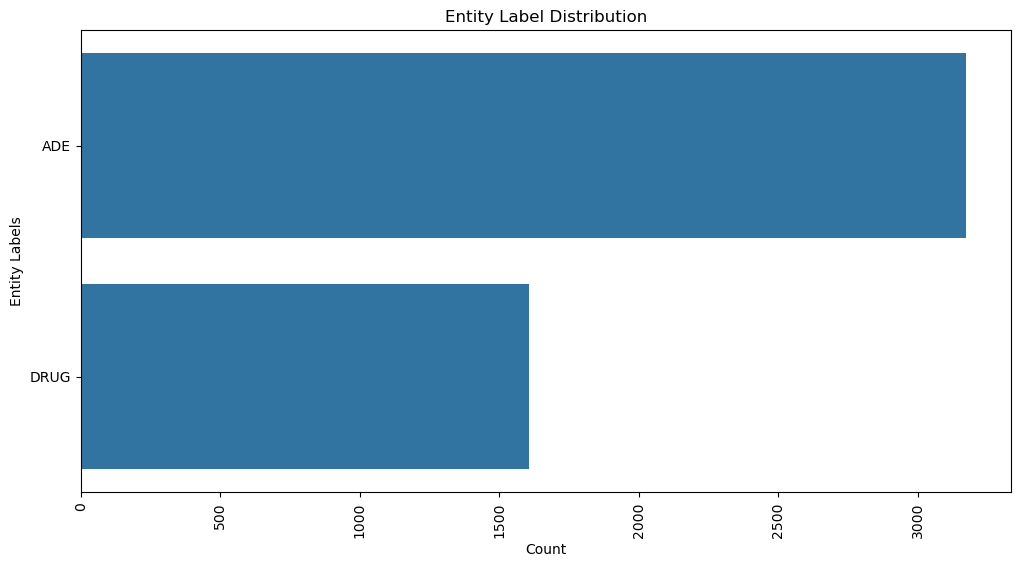

In [176]:
# Count entity label occurrences
label_counts = vaers_gold_annotated['label'].value_counts()

# Plot the distribution of entity labels
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.values , y=label_counts.index)
plt.title('Entity Label Distribution')
plt.xlabel('Count')
plt.ylabel('Entity Labels')
plt.xticks(rotation=90)
plt.show()


### ADE entitiy values distribution

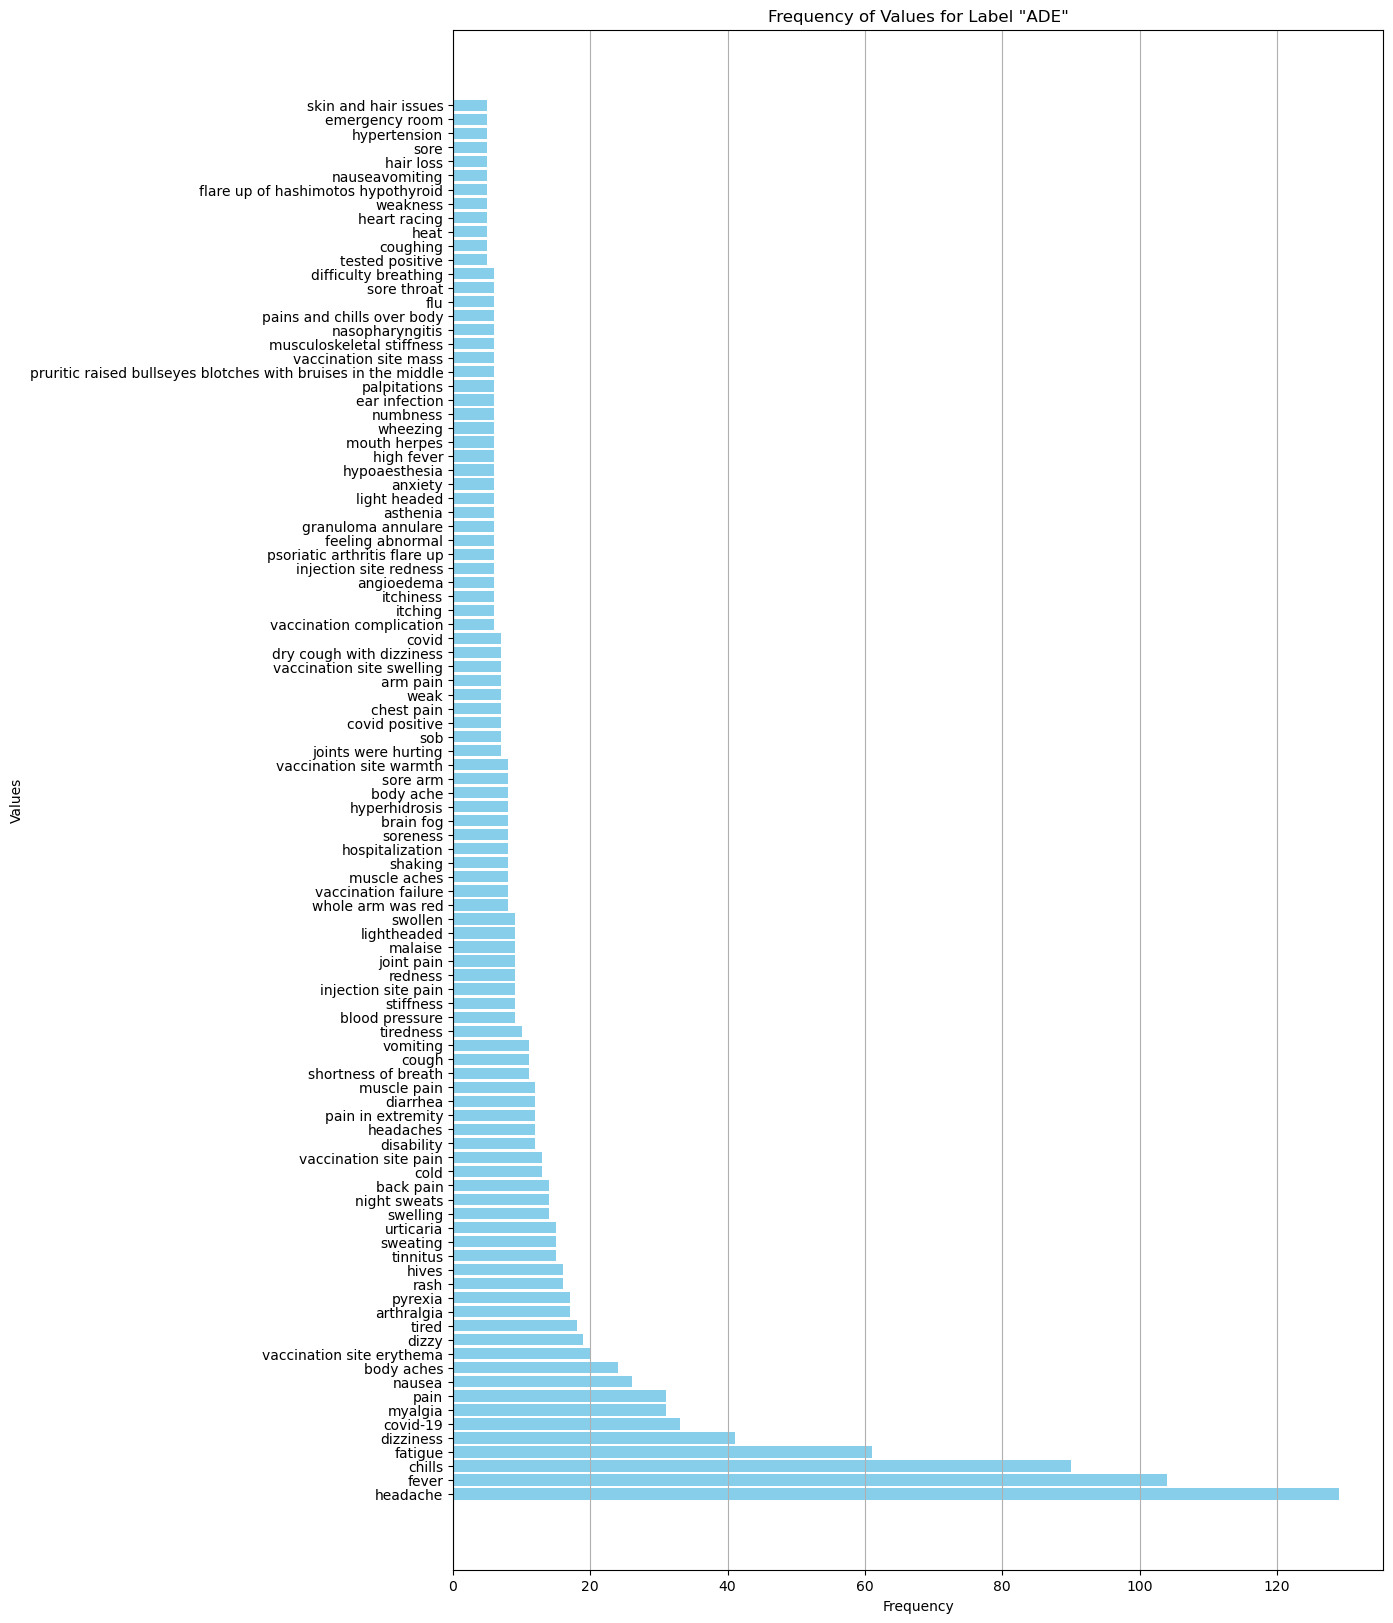

In [177]:
# Step 1: Filter the DataFrame for the label "ADE"
entity_ADE = vaers_gold_annotated[vaers_gold_annotated['label'] == 'ADE']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_ADE = entity_ADE['entity_value'].str.lower().value_counts()
top_10_value_counts_ADE = value_counts_ADE.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_ADE.index, top_10_value_counts_ADE.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "ADE"')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

In [178]:
print('Yes') if any(ade for ade in value_counts_ADE if ade == 'mrna-1273') else print('No')

No


### DRUG entitiy values distribution

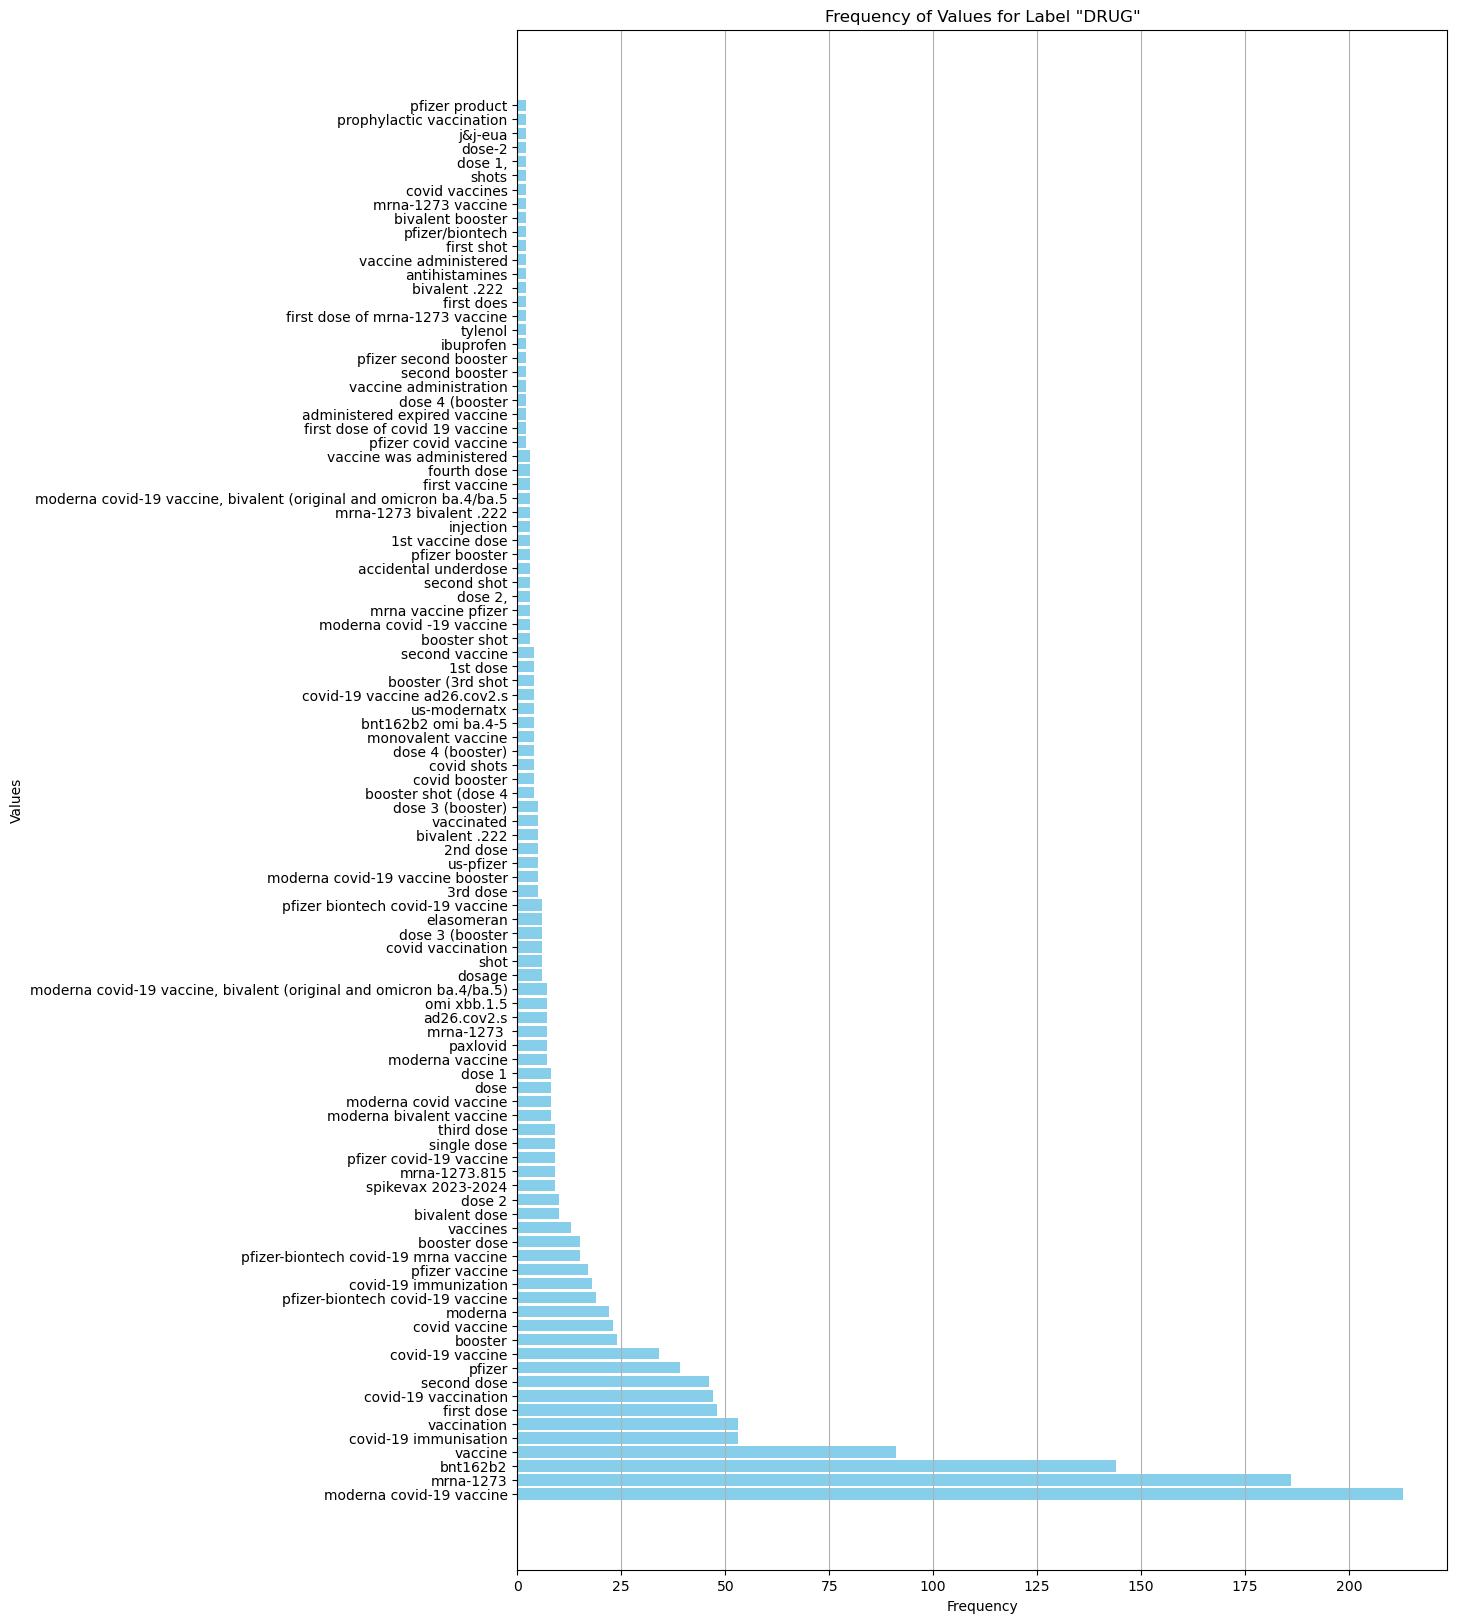

In [179]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG = vaers_gold_annotated[vaers_gold_annotated['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG = entity_DRUG['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG = value_counts_DRUG.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG.index, top_10_value_counts_DRUG.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG"')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

### Entity length stats

In [181]:
# compute span length for each row
vaers_gold_annotated["span_length"] = vaers_gold_annotated.apply(
    lambda row: len(row["symptom_text"][row["start"]:row["end"]].split()), axis=1
)

# get span length stats per entity label
span_stats_by_label = vaers_gold_annotated.groupby("label")["span_length"].describe()

print(span_stats_by_label)

        count      mean       std  min  25%  50%  75%   max
label                                                      
ADE    3175.0  2.729764  2.247181  1.0  1.0  2.0  4.0  17.0
DRUG   1607.0  1.921593  1.030700  1.0  1.0  2.0  3.0   8.0


### Box plot: Entity length 

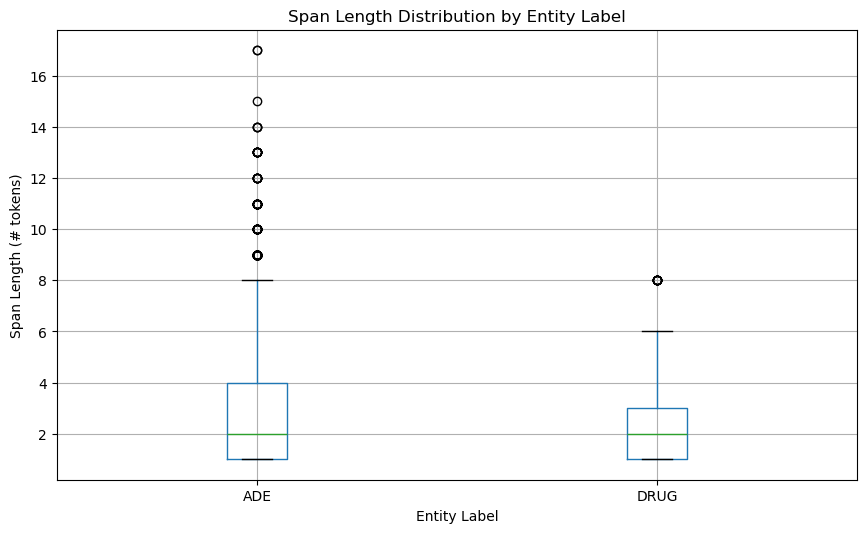

In [182]:
vaers_gold_annotated.boxplot(column="span_length", by="label", figsize=(10,6))
plt.title("Span Length Distribution by Entity Label")
plt.suptitle("")
plt.xlabel("Entity Label")
plt.ylabel("Span Length (# tokens)")
plt.show()


In [184]:
# saving cleaned GOLD annotated dataset
vaers_gold_annotated.to_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/gold_annotated_data/vaers_gold_annotated_cleaned.csv', index=False)